In [68]:
import numpy as np
import pandas as pd
import plotly.express as px
import json
from glob import glob
from pathlib import Path
from tqdm import tqdm
%matplotlib inline
import random
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import MaxAbsScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
import pymongo
import plotly.express as px
import math
from enum import Enum
from tqdm.notebook import tqdm
import multiprocessing as mp


In [97]:
class InstanceType(Enum):
    ALL = 1
    OPTIMIZATION = 2
    SAT = 3

data_types_to_consider = InstanceType.OPTIMIZATION

def string_to_instance_type(s):
    return InstanceType.SAT if s == 'SAT' else InstanceType.OPTIMIZATION


In [2]:
base = "data/done-soon/temp/problem_output/"
all_normal_files = glob("data/problem_output/*NORMAL.json")
df = pd.DataFrame()
data = []


# find index of statistics array at certain percent of TL
def find_index_at_percent(stats, percent):
    left = 0
    right = len(stats) - 1
    while left < right:
        mid = (left + right) // 2
        
        if stats[mid] is not None:

            if stats[mid]['search_time'] == percent:
                # Found the first dictionary with target time
                while mid > 0 and stats[mid-1]['search_time'] == percent:
                    mid -= 1
                return mid
            elif stats[mid]['search_time'] < percent:
                left = mid + 1
            else:
                right = mid - 1
        else:
            return -1

    return -1


num_without_search_time = 0
for i, normal in tqdm(enumerate(all_normal_files)):
    mzn = normal[normal.find("MZN-")+4:normal.find("-DZN")] + ".mzn"
    dzn = normal[normal.find("DZN-")+4:normal.find("-OUTPUT")] + ".dzn"

    stats = Path(f"{normal[:-12]}-STATS.json")
    if stats.exists():
        with open(normal, 'r') as normal_output, open(f"{normal[:-12]}-STATS.json", 'r') as stats_output:
            line = normal_output.readline()
            if line: # don't read json from empty output
                
                normal_time = json.loads(line).get('time') # wall time
                stats_all_lines = [json.loads(line).get('statistics') for line in stats_output.readlines()]
                final_statistic = stats_all_lines[-1]
                
                
                
                if normal_time and final_statistic:
                    if "search_time" not in final_statistic.keys():
                            num_without_search_time += 1
                    else:
                            normal_time *= 0.001 # Convert from milliseconds to seconds

                            if normal_time <= 10:
                                continue

                            # To avoid loading in too much data into memory, only load the ones at certain percentages
                            # specifically, every half percent intervals
                            statistics_per_half_percent = []
                            for percent in range(1, 200):
                                percent /= 2
                                

                                # normal_time is in seconds, so this is percentage of two hours
                                wall_clock_time_at_percent = (60 * 60 * 2) * percent/100  

                                if wall_clock_time_at_percent >= final_statistic['search_time']: # no more data :(
                                    break 

                                statistics_per_half_percent  += [
                                    stats_all_lines[find_index_at_percent(stats_all_lines, wall_clock_time_at_percent)]
                                ]



                            data.append({
                                'normal_time': normal_time,
                                'stat_time': final_statistic['search_time'],
                                'problem': normal,
                                'statistics': statistics_per_half_percent,
                                'mzn': mzn,
                                'dzn': dzn
                            })

df = pd.DataFrame(data)
all_data = df
all_data.shape

16814it [03:59, 70.09it/s] 


(1132, 6)

In [34]:
df

,normal_time,stat_time,problem,statistics,mzn,dzn
0,7.200882,7199.268198,data/problem_output/PROB-city-position-MZN-cit...,"[{'conflicts': 389380, 'ewma_conflicts': 38936...",city-position.mzn,city-7-04.dzn
1,7.210505,7121.926723,data/problem_output/PROB-2DBinPacking-MZN-2DPa...,"[{'conflicts': 631941, 'ewma_conflicts': 63192...",2DPacking.mzn,Class5_80_8.dzn
2,0.071478,213.285878,data/problem_output/PROB-amaze-MZN-amaze2-DZN-...,"[{'conflicts': 269053, 'ewma_conflicts': 26903...",amaze2.mzn,2012-07-05.dzn
3,7.201437,3512.053385,data/problem_output/PROB-ship-schedule-MZN-shi...,"[{'conflicts': 870438, 'ewma_conflicts': 87041...",ship-schedule.mip.mzn,8ShipsUnconst.dzn
4,7.201694,7199.867735,data/problem_output/PROB-miplib-MZN-ns4-pr6-DZ...,"[{'conflicts': 1141428, 'ewma_conflicts': 1141...",ns4-pr6.mzn,NO-MODEL-FILE.dzn
...,...,...,...,...,...,...
1127,0.010501,42.884265,data/problem_output/PROB-wwtpp-real-MZN-wwtpp-...,"[{'conflicts': 28032, 'ewma_conflicts': 28013....",wwtpp.mzn,ex02400_2400_100.dzn
1128,0.018754,229.142342,data/problem_output/PROB-rcpsp-wet-MZN-rcpsp-w...,"[{'conflicts': 350115, 'ewma_conflicts': 35009...",rcpsp-wet.mzn,j30_1_3-wet.dzn
1129,0.011433,45.670814,data/problem_output/PROB-2DBinPacking-MZN-2DPa...,"[{'conflicts': 91212, 'ewma_conflicts': 91193....",2DPacking.mzn,Class4_40_7.dzn
1130,0.016353,77.763970,data/problem_output/PROB-mrcpsp-MZN-mrcpsp-DZN...,"[{'conflicts': 204350, 'ewma_conflicts': 20433...",mrcpsp.mzn,j30_46_4.dzn


In [49]:
def cleanup(df):
    if "decision_level_sat" in df:
        del df["decision_level_sat"]
    if "ewma_decision_level_mip" in df:
        del df["ewma_decision_level_mip"]
    if "decision_level_mip" in df:
        del df["decision_level_mip"]
#     del df["best_objective"]
#     df["unassnVar"]   = (2**df['vars']) - df['opennodes']
#     df["fracFailUnassn"]     = df['conflicts'] / df['unassnVar']         # num failures/ num open nodes
    df["fracOpenVisit"]  = (df['vars'] - df['opennodes']) / df['opennodes']       # ratio of open nodes to visited nodes (how much of soln space explored)
    df["fracBoolVars"]     = df['boolVars'] / df['vars']                 # num bools / total num of vars
    df["fracPropVars"]     = df['propagations'] / df['vars']        # num propagations/ total num of vars
#     df["frac_unassigned"] = df['unassnVar'] / df['vars']  # current assignments/ total vars
    df["fracLongClauses"] = df['long'] + df['bin'] + df['tern']         # fraction of learnt clauses that have more than 3 literals
    df["freqBackjumps"]  = df['back_jumps']/df['search_time']
    return df


def gradients(df_prev, df_curr):
    keys=['conflicts','ewma_conflicts','decisions','search_iterations','opennodes','ewma_opennodes',
          'vars','back_jumps','ewma_back_jumps','solutions','total_time','search_time','intVars',
          'propagations','sat_propagations','ewma_propagations','propagators','boolVars','learnt',
          'bin','tern','long','peak_depth','decision_level_engine','ewma_decision_level_engine',
          'decision_level_treesize','clause_mem','prop_mem','ewma_best_objective',
          'fracOpenVisit','fracBoolVars','fracPropVars','freqBackjumps', 'best_objective']
    for i in keys:
        df_curr[i+'_gradient']=(df_curr[i]-df_prev[i])/0.05*7200
    return df_curr

In [41]:
all_data_filtered = all_data[all_data['normal_time'] > 10]
all_data_filtered.shape
print(all_data_filtered.iloc[[0]].statistics[0][0].keys())

dict_keys(['conflicts', 'ewma_conflicts', 'decisions', 'search_iterations', 'opennodes', 'ewma_opennodes', 'vars', 'back_jumps', 'ewma_back_jumps', 'solutions', 'total_time', 'search_time', 'intVars', 'propagations', 'sat_propagations', 'ewma_propagations', 'propagators', 'boolVars', 'learnt', 'bin', 'tern', 'long', 'peak_depth', 'decision_level_engine', 'ewma_decision_level_engine', 'decision_level_sat', 'decision_level_treesize', 'clause_mem', 'prop_mem', 'decision_level_mip', 'ewma_decision_level_mip', 'best_objective', 'ewma_best_objective'])


In [146]:
features_at_percent = {}


for i in tqdm(range(1,200)):
    df_i=[]
    number = 0
    for id, problem in all_data_filtered.iterrows():
        
        if i >= len(problem.statistics):
            continue
        
        p = problem.statistics[i]

        # Apparently there are four instances that do not have all keys. No clue what happened there.
        if len(p.keys()) != 33:
            number += 1
            continue
        
        new_p = dict(p)
        new_p=cleanup(new_p)
        if i!=1:
            new_p=gradients(df_prev.loc[id], new_p)
        new_p['mzn'] = problem['mzn']
        new_p['dzn'] = problem['dzn']
        new_p['solved_within_time_limit'] = problem['normal_time'] < 7199
        df_i.append((id, new_p))

    df_i = pd.DataFrame([a[1] for a in df_i], index=[a[0] for a in df_i])
    df_i=df_i.fillna(value = 0)
    if i!=0:   
        features_at_percent[i]=df_i
    df_prev=df_i



  0%|          | 0/199 [00:00<?, ?it/s]

## Train test split

In [147]:
def preprocessing(df):
    df1=df.drop(['mzn','dzn'], axis=1)
    df1.drop(df1.columns[df1.nunique() == 1], axis=1, inplace=True) #drop cols with constant value
    #rescale data
    transformer = MaxAbsScaler().fit(df1)
    df1 = pd.DataFrame(transformer.transform(df1), columns=df1.columns, index=df1.index) #normalise data
    return df1

In [105]:
def create_split(df, test_size=0.25, random_state=22):
    return train_test_split(df.drop(columns = ["solved_within_time_limit"]),\
                                df["solved_within_time_limit"], test_size=0.25, random_state=22)


In [106]:
df=features_at_percent[5] #THE NUMBER HERE IS THE % OF TL
df=preprocessing(df)
# training-testing split
X_train, X_test, y_train, y_test  = train_test_split(df.drop(columns = ["solved_within_time_limit"]),\
                                                     df["solved_within_time_limit"], test_size=0.25, random_state=22)



In [124]:
y_train.value_counts()

0.0    369
1.0    216
Name: solved_within_time_limit, dtype: int64

In [123]:
y_test.value_counts()

0.0    119
1.0     76
Name: solved_within_time_limit, dtype: int64

In [107]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['LR'] = LogisticRegression(max_iter=1000, C=1000 , class_weight = 'balanced',random_state=22)

#Support Vector Machine
from sklearn.svm import SVC
models['SVM'] = SVC(kernel = 'rbf', class_weight = 'balanced', probability = True, random_state=22)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['RF'] = RandomForestClassifier(min_samples_leaf = 5, class_weight = 'balanced_subsample',random_state=22)

#Extra Tree
from sklearn.ensemble import ExtraTreesClassifier
models['ET'] = ExtraTreesClassifier(class_weight = 'balanced', random_state=22)

#Multi-layered perceptron
from sklearn.neural_network import MLPClassifier
models['MLP'] = MLPClassifier(random_state=22)

# Naive Bayes
#from sklearn.naive_bayes import GaussianNB
#models['NB'] = GaussianNB()

# Adaboost
from sklearn.ensemble import AdaBoostClassifier
models['AB'] = AdaBoostClassifier()

#KNN
#from sklearn.neighbors import KNeighborsClassifier
#models['KNN'] = KNeighborsClassifier(weights = 'distance')

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['DT'] = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', random_state=22)

#Dummy classifier
from sklearn.dummy import DummyClassifier
models['DUM'] = DummyClassifier(strategy="most_frequent")

In [122]:
rf_reg = RandomForestClassifier(min_samples_leaf = 5)
rf_reg.fit(X_train,y_train)

predictions = rf_reg.predict(X_test)
importances = rf_reg.feature_importances_

print('The F1 score with all features of a RandomForestClassifier with min_samples_leaf of 5 is ', f1_score(y_test, predictions))

The F1 score with all features of a RandomForestClassifier with min_samples_leaf of 5 is  0.913907284768212


In [125]:
print(X_train.columns)

Index(['conflicts', 'ewma_conflicts', 'decisions', 'search_iterations',
       'opennodes', 'ewma_opennodes', 'vars', 'back_jumps', 'ewma_back_jumps',
       'solutions', 'total_time', 'search_time', 'intVars', 'propagations',
       'sat_propagations', 'ewma_propagations', 'propagators', 'boolVars',
       'learnt', 'bin', 'tern', 'long', 'peak_depth', 'decision_level_engine',
       'ewma_decision_level_engine', 'decision_level_treesize', 'clause_mem',
       'prop_mem', 'best_objective', 'ewma_best_objective', 'fracOpenVisit',
       'fracBoolVars', 'fracPropVars', 'fracLongClauses', 'freqBackjumps'],
      dtype='object')


35


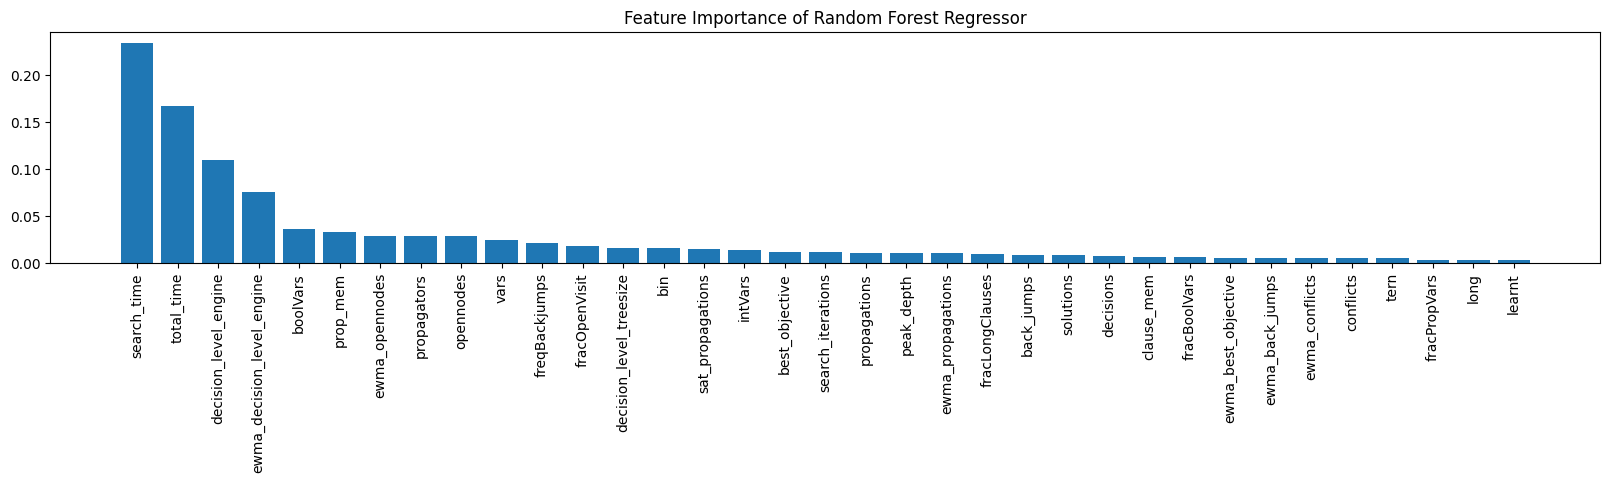

In [131]:


sorted_importance_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance of Random Forest Regressor')
plt.bar(range(len(sorted_importance_indices)), importances[sorted_importance_indices], align='center')
plt.xticks(range(len(sorted_importance_indices)), X_train.columns[sorted_importance_indices], rotation=90)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()



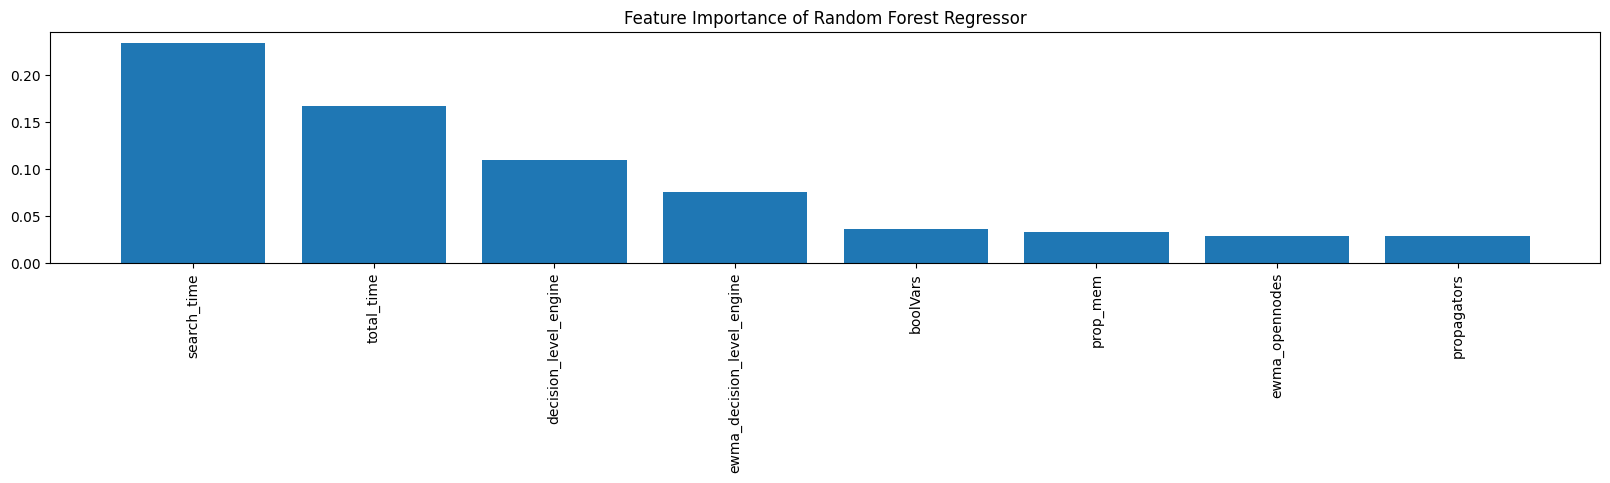

In [127]:
sorted_importance_indices = np.argsort(importances)[::-1][:8]

plt.title('Feature Importance of Random Forest Regressor')
plt.bar(range(8), importances[sorted_importance_indices], align='center')
plt.xticks(range(8), X_train.columns[sorted_importance_indices], rotation=90)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()


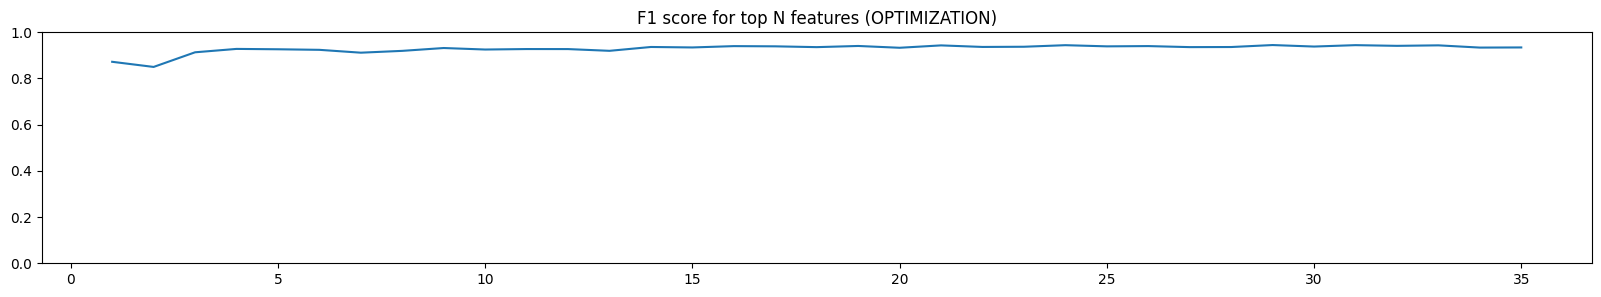

[(35, 0.9343403501573805), (34, 0.9337487859794791), (33, 0.9434238250448038), (32, 0.9412613293866846), (31, 0.9442784202628867), (30, 0.9382206019533885), (29, 0.944701446325389), (28, 0.9361550145265891), (27, 0.935740548193419), (26, 0.9402252322506056), (25, 0.9390715861681744), (24, 0.9441094212076534), (23, 0.9373588454321637), (22, 0.9365111081807708), (21, 0.9432094228602891), (20, 0.9329413523532966), (19, 0.9407362889501577), (18, 0.9356843855147744), (17, 0.9391519146559087), (16, 0.9400596676774062), (15, 0.9343208522856654), (14, 0.9363443384839906), (13, 0.9197217753121967), (12, 0.927249452747174), (11, 0.9273816210209127), (10, 0.9253338349817627), (9, 0.9318456796650316), (8, 0.9195526251104086), (7, 0.9116593519054002), (6, 0.9239932093230676), (5, 0.9264250314359807), (4, 0.9279874002821342), (3, 0.9133613497741114), (2, 0.8499672081054948), (1, 0.8722301501987582)]


In [132]:
sorted_importance_indices = np.argsort(importances)[::-1][:35]

def f1_with_n_top_features(n, importance_column_indices):
    summed = 0
    for i in range(0, 10):
        X_train, X_test, y_train, y_test  = train_test_split(df.drop(columns = ["solved_within_time_limit"]),\
                                                     df["solved_within_time_limit"], test_size=0.25)
        rf_reg = RandomForestClassifier(min_samples_leaf = 5)
        rf_reg.fit(X_train.iloc[:, importance_column_indices[:n]], y_train)

        predictions = rf_reg.predict(X_test.iloc[:, importance_column_indices[:n]])
        summed += f1_score(y_test, predictions)
    return summed / 10



f1_scores = [(i, f1_with_n_top_features(i, sorted_importance_indices)) for i in range(1, len(sorted_importance_indices) + 1)[::-1]]

plt.title(f'F1 score for top N features ({"OPTIMIZATION" if data_types_to_consider is InstanceType.OPTIMIZATION else "SAT"})')
plt.plot([a[0] for a in f1_scores], [a[1] for a in f1_scores])
plt.gca().set_ylim([0,1])
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

print(f1_scores)

In [133]:
def results_plt(X_train, y_train, X_test, y_test, perc_TL):
    train_accuracy, accuracy, precision, recall, auc, f1 = {}, {}, {}, {}, {}, {}
    figs, axs = plt.subplots(2,3,figsize=(20, 12))

    for i, key in enumerate(models.keys()):

        # Fit the classifier model
        models[key].fit(X_train, y_train)

        predictions = models[key].predict(X_test)
        predictions_prob = models[key].predict_proba(X_test)[:,1]
        train_predictions = models[key].predict(X_train)
        # Predic  
        # Calculate Accuracy, Precision and Recall Metrics
        accuracy[key] = accuracy_score(predictions, y_test)
        precision[key] = precision_score(predictions, y_test, zero_division=1)
        recall[key] = recall_score(predictions, y_test, zero_division=1)
        auc[key] = roc_auc_score(y_test, predictions_prob)
        train_accuracy[key] = accuracy_score(train_predictions, y_train)
        f1[key] = f1_score(y_test,predictions)
        #should it be (true, pred)? yes

        #To Display
        RocCurveDisplay.from_predictions(y_test, predictions_prob, name=key , ax=axs[0,0])
        axs[0,1].bar(key, accuracy[key]) 
        axs[0,2].bar(key, train_accuracy[key]) 
        axs[1,0].bar(key, recall[key])
        axs[1,1].bar(key, precision[key])
        axs[1,2].bar(key, f1[key])

        axs[0,0].set_title("ROC Curve for "+perc_TL+"% TL")
#         axs[0].set_ylabel("Accuracy")

        axs[0,1].set_title("Test Accuracy for "+perc_TL+"% TL")
        axs[0,1].set_ylabel("Accuracy")
        axs[0,1].grid(axis='y', color='gray', linestyle='dashed')

        axs[0,2].set_title("Train Accuracy for "+perc_TL+"% TL")
        axs[0,2].set_ylabel("Accuracy")
        axs[0,2].grid(axis='y', color='gray', linestyle='dashed')

        axs[1,0].set_title("Recall for "+perc_TL+"% TL")
        axs[1,0].set_ylabel("Recall")
        axs[1,0].grid(axis='y', color='gray', linestyle='dashed')


        axs[1,1].set_title("Precision "+perc_TL+"% TL")
        axs[1,1].set_ylabel("F1")
        axs[1,1].grid(axis='y', color='gray', linestyle='dashed')

        axs[1,2].set_title("F1 "+perc_TL+"% TL")
        axs[1,2].set_ylabel("F1")
        axs[1,2].grid(axis='y', color='gray', linestyle='dashed')
        
        
        [axs[y, x].tick_params(axis='x', labelrotation=60) for y in range(len(axs)) for x in range(len(axs[y]))]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


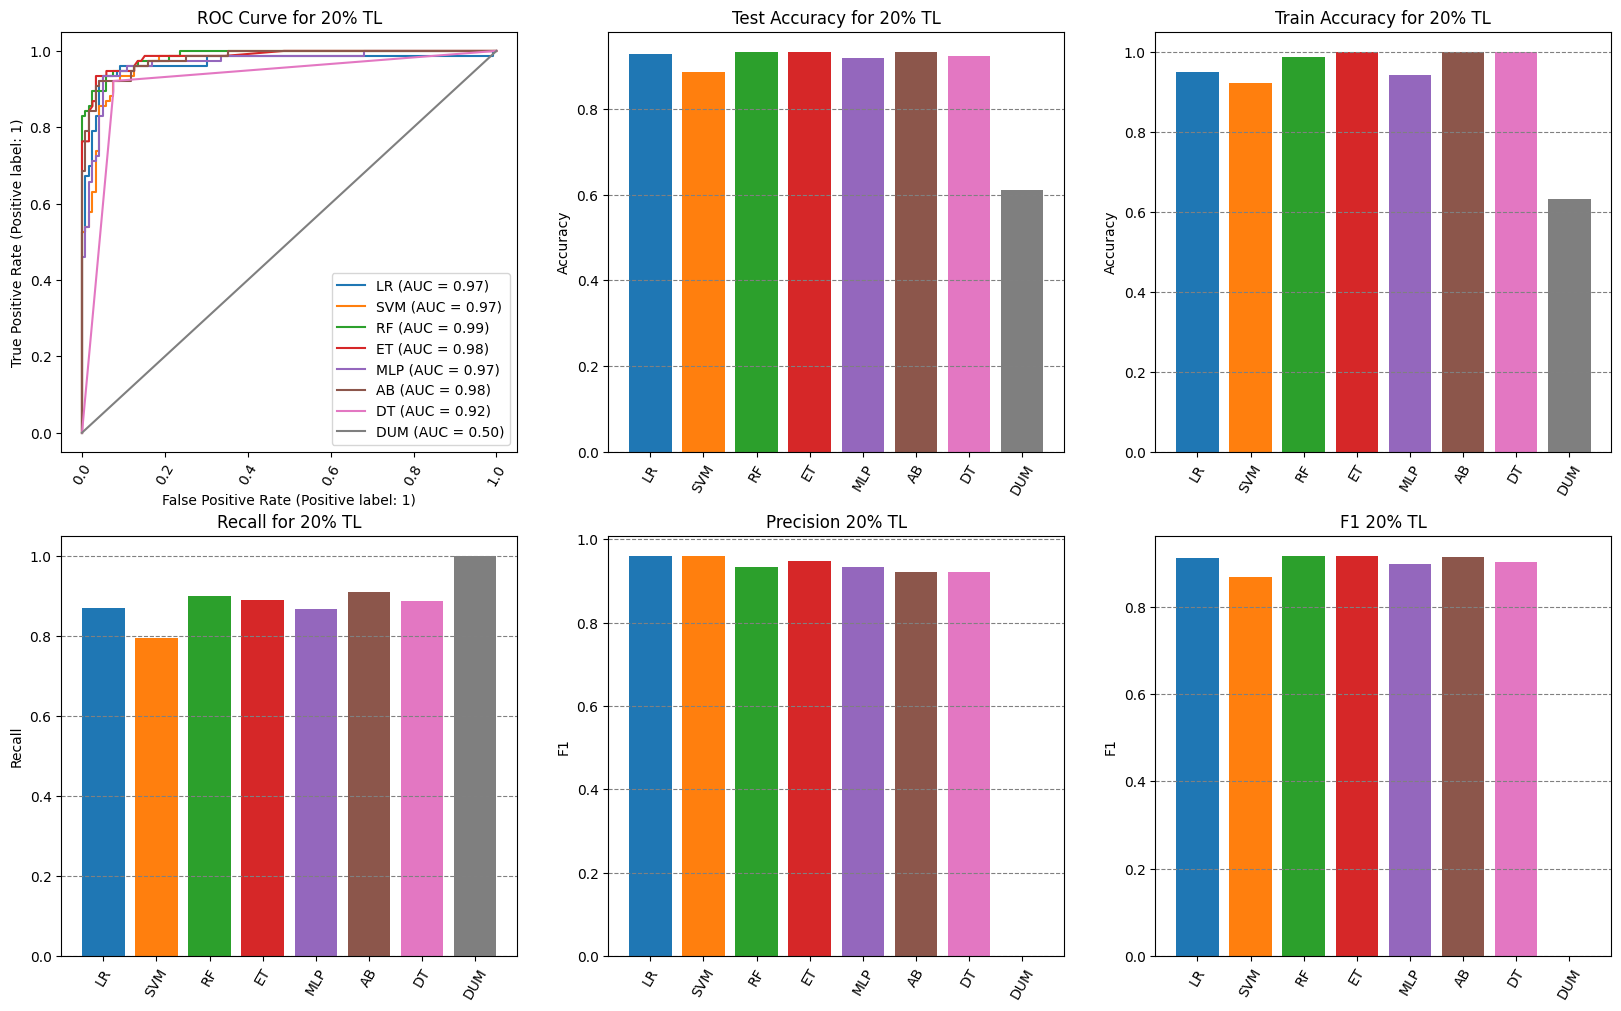

In [134]:


#Bar plot results  for testing and training using top 5 created features

results_plt(X_train, y_train, X_test, y_test, "20")



In [148]:


def get_f1_scores(args):
    features_at_percent, percent, rep = args
    df_at_percent = features_at_percent[percent]
    if df_at_percent.empty:
        return 0
    df_at_percent = preprocessing(df_at_percent)
    if df_at_percent.empty:
        return 0

    X_train, X_test, y_train, y_test  = create_split(df_at_percent, random_state=percent + (100 * rep))
    model = RandomForestClassifier(min_samples_leaf = 5, class_weight = 'balanced_subsample',random_state=percent + (100 * rep))
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    return f1_score(y_test, predictions)

def get_f1_over_time_for_model(features_at_percent, repetitions=10):
    f1_scores_mean = []
    f1_scores_std = []
    for percent in tqdm(range(1, 200), desc="Percent"):
        with mp.Pool(mp.cpu_count()) as pool:
            f1_scores = list(tqdm(pool.imap(get_f1_scores,
                                            [(features_at_percent, percent, rep) for rep in range(repetitions)]),
                                  total=10, leave=False, desc="Repetitions"))

            f1_scores_mean.append(np.mean(f1_scores))
            f1_scores_std.append(np.std(f1_scores))
        
    return f1_scores_mean, f1_scores_std
    

In [150]:
f1_scores_mean, f1_scores_std = get_f1_over_time_for_model(features_at_percent)

Percent:   0%|          | 0/199 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

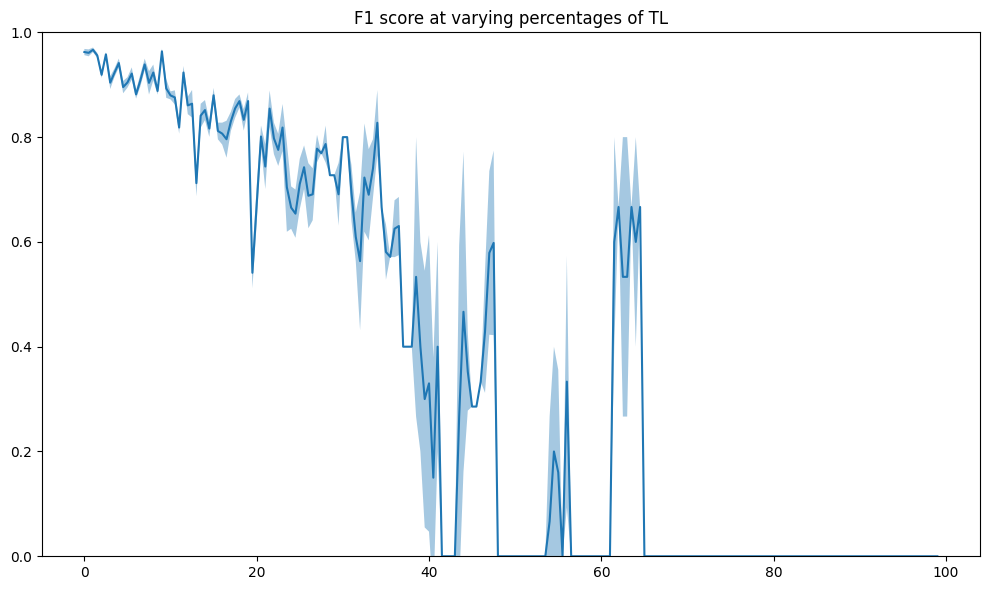

In [160]:


plt.ylim((0, 1))
y = np.array(f1_scores_mean)
err = np.array(f1_scores_std)

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(np.arange(0, 99.5, 0.5), y)
plt.title("F1 score at varying percentages of TL")
plt.fill_between(np.arange(0, 99.5, 0.5), y - err, y + err, alpha=0.4)
plt.tight_layout()
plt.savefig("f1_over_time.svg")

